# Development and testing of the Balanced Data Sampler

The graph data for this project is highly variable in size, leading to load imbalance issues when training distributed.

This notebook is for developing the balanced batch sampler for training our GNNs in a load-balanced way. We use the Etalumis batch sampler for inspiration, copied to Jacob's repo here for now:
https://github.com/jbalma/heptrkx-gnn-tracking/blob/master/datasets/loadbal_sampler.py

Here's what the etalumis batch sampler essentially does
1. Sorts the file list by size
2. Chunks the sorted list into mini-batches (local batch size)
3. Chunks the mini-batches into buckets
4. In each epoch,
  - shuffle the buckets and shuffle the mini-batches in each bucket
  - loop over buckets and over mini-batches in each bucket, yielding indices

Consequences
* by building minibatches from the sorted list, guaranteed to have the most similar samples in a batch.
* however, mini-batches are formed from fixed sets of samples
* buckets are shuffled each epoch, but within an epoch, each bucket is fully processed before moving on to the next

Here's what I think we'd like to do instead
1. Sort the file list
2. Chunks the samples into buckets
3. In each epoch,
  - shuffle the samples within each bucket
  - chunk each bucket into mini-batches
  - Shuffle the mini-batches
  - Loop over the mini-batches and yield the indices

**Structure of this notebook**
1. Define and build a metadata dataset which just contains the sizes of the graphs. We don't need to fully load the graphs for these tests
2. Implement a simple balanced batch sampler without distributed training support
3. Compare batch loading from a regular pipeline to the balanced one and plot the sample size variance
4. Implement a *distributed* balanced batch sampler
5. Test the distributed balanced batch sampler

In [1]:
# System imports
import os
import sys

In [2]:
# External imports
import numpy as np
import pandas as pd
import torch
from torch.utils.data import DataLoader
from torch_geometric.data import Batch

import matplotlib.pyplot as plt

In [3]:
# Local imports
sys.path.append('..')
from datasets.hitgraphs_sparse import HitGraphDataset

In [4]:
%matplotlib inline

In [5]:
plt.rcParams['font.size'] = 16.0

## Configuration

In [6]:
input_dir = os.path.expandvars('${SCRATCH}/heptrkx/data/hitgraphs_high_002')
#n_train = 32768
batch_size = 32
n_buckets = 32

## Build and load the metadata

In [7]:
def process_file(filename):
    with np.load(filename) as f:
        n_nodes = f['X'].shape[0]
        n_edges = f['y'].shape[0]
        purity = f['y'].mean()
    return dict(n_nodes=n_nodes, n_edges=n_edges, purity=purity)

def prepare_metadata(data_dir, n_files=None):
    files = [os.path.join(data_dir, f) for f in os.listdir(data_dir)
             if not f.endswith('_ID.npz')]
    print('%i total files' % len(files))
    if n_files is not None:
        files = files[:n_files]
    return (pd.DataFrame.from_records([process_file(f) for f in files])
            .assign(file=files))

def save_metadata(metadata, data_dir):
    metadata.to_csv(os.path.join(data_dir, 'metadata.csv'))

def read_metadata(data_dir):
    return pd.read_csv(os.path.join(data_dir, 'metadata.csv'))

In [17]:
class GraphSizeMetaDataset(torch.utils.data.Dataset):
    """Meta dataset just containing the node and edge counts of the graphs"""
    def __init__(self, metadata):
        self.metadata = metadata
    
    def __getitem__(self, index):
        return self.metadata[['n_nodes', 'n_edges']].iloc[index].values
    
    def __len__(self):
        return len(self.metadata)

In [ ]:
%%time

# Run this cell only if you need to make/remake the metadata
metadata = process_dataset(input_dir)
save_metadata(metadata, input_dir)

## Balanced sampler design

In [18]:
def compute_sizes(dataset):
    """
    Function which computes the size metric for a dataset.
    For our meta-dataset containing the sizes, we'll for now just use the number of edges.
    """
    return dataset.metadata.n_edges.values

In [19]:
class BalancedBatchSampler(torch.utils.data.Sampler):
    def __init__(self, dataset, batch_size, n_buckets, size_fn=compute_sizes):
        self.dataset = dataset
        self.batch_size = batch_size
        
        # Compute the sizes of each sample in the dataset.
        self.sample_sizes = size_fn(dataset)
        
        # Make buckets from sorted sample indices
        self.buckets = self.sample_sizes.argsort().reshape(-1, n_buckets)
    
    def __iter__(self):

        # Shuffle samples within each bucket
        for bucket in self.buckets:
            np.random.shuffle(bucket)
        
        # Form batches - here I copy to avoid repeating sort + bucket
        batches = self.buckets.copy().reshape(-1, self.batch_size)

        # Shuffle the batches
        np.random.shuffle(batches)
        
        # Loop and yield batch indices
        for batch in batches:
            yield batch
    
    def __len__(self):
        return len(self.dataset) // self.batch_size

## Prepare the data pipelines for comparison

In [20]:
# Construct the dataset
metadata = read_metadata(input_dir)
dataset = GraphSizeMetaDataset(metadata)

In [21]:
# Normal loader with default sampler
basic_loader = DataLoader(dataset, batch_size=batch_size)

In [22]:
%%time

# Balanced loader
balanced_sampler = BalancedBatchSampler(dataset, batch_size=batch_size, n_buckets=n_buckets)
balanced_loader = DataLoader(dataset, batch_sampler=balanced_sampler)

CPU times: user 6.53 ms, sys: 1.11 ms, total: 7.64 ms
Wall time: 6.38 ms


## Compare graph variability

We're going to look at the mini-batch standard deviations of graph size (nodes and edges).

In [24]:
%%time

# Uniform data sampling
basic_stddev = np.stack([batch.numpy().std(axis=0) for batch in basic_loader])

CPU times: user 1min 11s, sys: 27.9 s, total: 1min 39s
Wall time: 1min 39s


In [25]:
%%time

# Balanced data sampling
balanced_stddev = np.stack([batch.numpy().std(axis=0) for batch in balanced_loader])

CPU times: user 1min 11s, sys: 27.8 s, total: 1min 39s
Wall time: 1min 39s


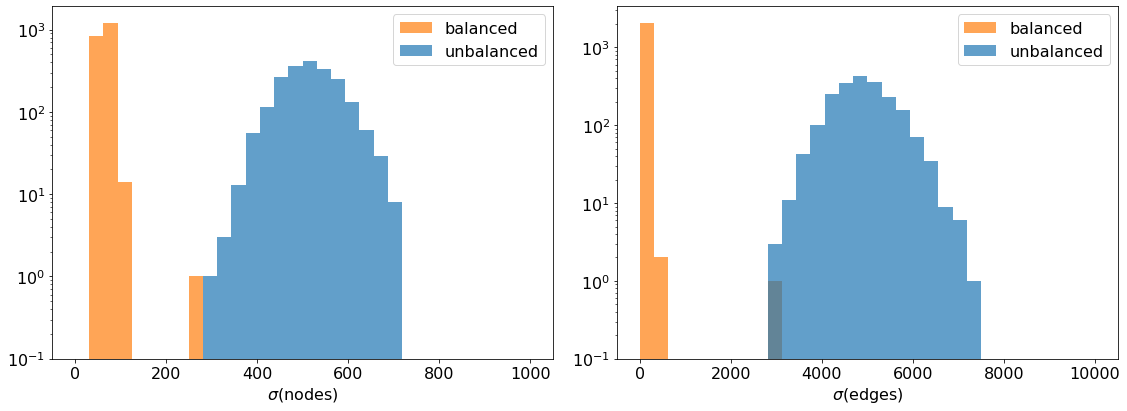

In [26]:
fig, (ax0, ax1) = plt.subplots(ncols=2, figsize=(16, 6))

ax0.hist((basic_stddev[:,0], balanced_stddev[:,0]),
         bins=32, range=(0, 1000), log=True,
         histtype='stepfilled', alpha=0.7,
         label=('unbalanced', 'balanced'))
ax1.hist((basic_stddev[:,1], balanced_stddev[:,1]),
         bins=32, range=(0, 10000), log=True,
         histtype='stepfilled', alpha=0.7,
         label=('unbalanced', 'balanced'))

ax0.set_xlabel('$\sigma$(nodes)')
ax1.set_xlabel('$\sigma$(edges)')
ax0.legend(loc=0)
ax1.legend(loc=0)
plt.tight_layout()

## Discussion

I have a basic balanced sampler in place and have demonstrated the potential for greatly reduced graph size variance. This is good.

The sampler is not yet distributed, so I need to enable that functionality.

**I need to implement deterministic epoch-based shuffling for this to work**

## Going distributed

What will it take to make this design work in the distributed setting?

In the etalumis code, it seems they keep random shuffling consistent across ranks and then break up the mini-batches accordingly.
This might be the only way to really do things effectively, because I cannot let each rank separately shuffle different subsets of data.

Let's review how it's done in the offical pytorch distributed sampler.

https://pytorch.org/docs/stable/_modules/torch/utils/data/distributed.html#DistributedSampler

They have deterministic shuffling based on epoch number. This would be useful to replicate here.

I may need to think about how to enable seamless switching of samplers. In the normal case, I use the DistributedSampler and call set_epoch.
In this case I won't even use a regular sampler but just a distributed batch sampler. I don't really want a bunch of control flow. So, maybe I should avoid having a set_epoch method.

The etalumis code updates epoch internally, which I like, though I might add an option to at least set an initial epoch in the constructor or otherwise for resuming from checkpoint.

I should be able to test the distributed setting here in this notebook by instantiating multiple samplers and manually setting ranks.

In [89]:
class DistributedBalancedBatchSampler(torch.utils.data.Sampler):
    def __init__(self, dataset, batch_size, n_buckets, rank=0, n_ranks=1, size_fn=compute_sizes):
        self.dataset = dataset
        self.batch_size = batch_size
        self.epoch = -1
        self.rank = rank
        self.n_ranks = n_ranks
        
        # Compute the sizes of each sample in the dataset.
        self.sample_sizes = size_fn(dataset)
        
        # Make buckets from sorted sample indices
        self.buckets = self.sample_sizes.argsort().reshape(-1, n_buckets)
    
    def __iter__(self):
        
        # Increment epoch
        self.epoch += 1
        
        # Deterministic shuffling based on epoch
        g = np.random.default_rng(self.epoch)
        
        # Shuffle samples within each bucket
        for bucket in self.buckets:
            g.shuffle(bucket)
        
        # Form batches - here I copy to avoid repeating sort + bucket
        global_batch_size = self.batch_size * self.n_ranks
        batches = self.buckets.copy().reshape(-1, global_batch_size)

        # Shuffle the batches
        g.shuffle(batches)
        
        # Loop and yield batch indices for this rank
        for batch in batches:
            yield batch[self.rank:global_batch_size:self.n_ranks]
    
    def __len__(self):
        return len(self.dataset) // self.batch_size

In [90]:
# Distributed config
n_buckets = 32
batch_size = 4
n_ranks = 2

In [91]:
# Balanced loaders
samplers = [DistributedBalancedBatchSampler(dataset, batch_size=batch_size,
                                            n_buckets=n_buckets,
                                            rank=r, n_ranks=n_ranks)
            for r in range(n_ranks)]

loaders = [DataLoader(dataset, batch_sampler=s) for s in samplers]

In [98]:
for batch0 in loaders[0]:
    break

for batch1 in loaders[1]:
    break

print(batch0)
print(batch1)

DistributedBalancedBatchSampler.__iter__
DistributedBalancedBatchSampler.__iter__
tensor([[ 3807, 17386],
        [ 4042, 17387],
        [ 3973, 17384],
        [ 3968, 17383]])
tensor([[ 3762, 17383],
        [ 3830, 17383],
        [ 4049, 17384],
        [ 3921, 17384]])


## Discussion

The distributed samplers appear to be working well.

## References and old code